In [14]:
import pandas as pd
import numpy as np
import glob
import os
import re
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings('ignore')

import shared_functions
animal_data_path = 'data/animal_data/'
human_data_path = 'data/human_data/'
catsNdogs_projects_info_path = 'data/animal_data/pets_SRR_info.txt'

In [16]:
# cat dog projects
def get_catNdog_projects():
    projects = glob.glob(os.path.join(animal_data_path,'PRJ*'))
    projects_name = list(map(os.path.basename,projects))
    projects_name = [ele.replace('_f1','') for ele in projects_name]
    data = shared_functions.read_data_set(zip(projects, projects_name),1)
    data.index = [ele.replace('_1','') for ele in data.index]
    data['Host_type'] = 'catNdog'
    # load host info
    host_info = pd.read_csv(catsNdogs_projects_info_path,index_col='Run',sep='\t')
    data = data.merge(host_info[['Host']],left_index=True,right_index=True)
    print('cat & dog projects:',len(pd.unique(data.project_name)))
    print('cat & dog projects:',len(data))
    return(data)
def get_human_projects():
    p_set = set()
    paths = []
    projects_list = []
    desiase_dirs = ['OB','PD','T2D','CVD','IBD']
    for d in desiase_dirs:
        projects = os.listdir(os.path.join(human_data_path,d,'HC'))
        for p in projects:
            if (p in p_set):
                continue
            paths.append(os.path.join(human_data_path,d,'HC',p))
            p_set.add(p)
            projects_list.append(p)
    data = shared_functions.read_data_set(zip(paths,projects_list),0)
    data.sort_index(inplace=True)
    data = data.groupby(data.index).agg('first')
    data['Host_type'] = 'human'
    data['Host'] = 'Homo sapiens'
    print('anothers human projects:',len(pd.unique(data.project_name)))
    print('anothers human projects:',len(data))
    return(data)

In [17]:
def fancy_plot(df,th,sm):
    sns.set_style("whitegrid")
    bins = [0]
    bins.extend(10.0**(np.arange(sm,1,step=1)))

    g = sns.JointGrid(x=df.iloc[0,:],y=df.iloc[1,:],height=5)
    g = g.plot_joint(sns.scatterplot, color="k",alpha=.6)
    _ = g.ax_marg_x.hist(df.iloc[0,:], color="c", bins=bins,alpha=.6)
    _ = g.ax_marg_y.hist(df.iloc[1,:], color="m", bins=bins,orientation="horizontal",alpha=.6)

    ax = g.ax_joint
    ax.axvline(x=th,color='c',alpha=.6,ls='dashed')
    ax.axhline(y=th,color='m',alpha=.6,ls='dashed')
    ax.set_xscale('symlog',linthreshx=10.0**(sm))
    ax.set_yscale('symlog',linthreshy=10.0**(sm))
    ax.set_xlim((-10.0**(sm)/2, 2))
    ax.set_ylim((-10.0**(sm)/2, 2))
    ax.set_xlabel('Taxon (genus) frequency in cats/dog samples')
    ax.set_ylabel('Taxon (genus) frequency in human samples')
    ax.fill([0,th,th,0], [0,0,th,th],'k',alpha=0.1)
def projects_table(data):
    x = data.groupby(['project_name','Host','Host_type']).size().sort_values(ascending=False).to_frame()
    x.columns = ['Samples #']
    x.sort_values(['Host','Samples #'],ascending=False,inplace=True)
    return(x)

In [18]:
def filter_data(taxa,host_group,nonzero_th=0.1,plotFreqHistogram=True):
    def _count_nonzero(x):
        return(len(x[x>0])/len(x))
    group_nonzero = taxa.groupby(host_group).agg([_count_nonzero])
    if (plotFreqHistogram):
        fancy_plot(group_nonzero,nonzero_th,-4)
    columns_to_stay = group_nonzero.loc[:,(group_nonzero>nonzero_th).any()].columns.droplevel(1)
    print('Filtered to:',len(columns_to_stay),'of',len(taxa.columns),'columns; non-zero threshold:',nonzero_th)
    return(columns_to_stay)

## Load and filter data

In [22]:
catsNdog_data = get_catNdog_projects()
humansA = get_human_projects()
df = pd.concat([catsNdog_data,humansA],sort=False)
df.fillna(0,inplace=True)
print(df.shape)
data = shared_functions.mydata(taxa_df = df.drop(['mean_chao','Host','Host_type','project_name'],axis=1),
                               chao_df = df['mean_chao'],
                               info_df = df.loc[:,['Host','Host_type','project_name']])

cat & dog projects: 12
cat & dog projects: 321
anothers human projects: 10
anothers human projects: 1242
(1563, 376)


Filtered to: 138 of 372 columns; non-zero threshold: 0.1


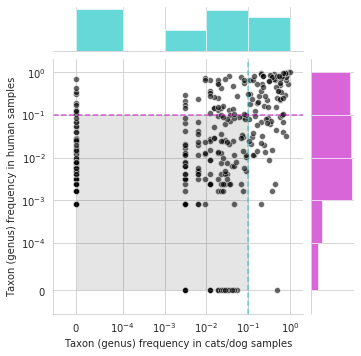

In [23]:
data_f = filter_data(data.taxa,data.info['Host_type'])
data.set_features(data_f)

## Make balanced calss sample 

In [24]:
di = data.info
cd = di[di.Host_type=='catNdog']
humans = di[(di.Host_type=='human')]
humans_sample = shared_functions.sample_equal_categories_iterative(humans,len(cd),'project_name',None,0)
cdh_dataset_info = pd.concat([cd,humans_sample])
print('humans:',humans.shape,'cats and dogs:',cd.shape,' humans sample:',
      humans_sample.shape,'balanced dataset',cdh_dataset_info.shape)

humans: (1242, 3) cats and dogs: (321, 3)  humans sample: (321, 3) balanced dataset (642, 3)


In [25]:
pt1 = projects_table(di)
pt2 = projects_table(cdh_dataset_info)
pt = pt1.merge(pt2,left_index=True,right_index=True,suffixes=('',' in balanced dataset')).sort_values(['Host_type','Host','Samples #','Samples # in balanced dataset'],ascending=False)
display(pt)

,,,Samples #,Samples # in balanced dataset
project_name,Host,Host_type,,
29795809,Homo sapiens,human,681,46
25417156,Homo sapiens,human,200,45
28195358,Homo sapiens,human,115,45
28179361,Homo sapiens,human,102,45
31027508,Homo sapiens,human,49,45
26179554,Homo sapiens,human,31,31
28429209,Homo sapiens,human,22,22
qiita_10928,Homo sapiens,human,21,21
29404425,Homo sapiens,human,12,12


In [ ]:
## write tables about projects used and dataset
pt.to_csv('results/catsNdogs_Table1_and_Table2_1.txt',sep='\t')
t2 = cdh_dataset_info.loc[:,['project_name','Host_type','Host']].sort_values(['Host_type','Host','project_name'])
t2.index = [ele.replace('.fastq','') for ele in t2.index]
t2['project_name'] = [ele.replace('_f1','') for ele in t2['project_name']]
t2.to_csv('results/catsNdogs_Table2.txt',sep='\t')

In [ ]:
# joblib sampled dataset for further usage
joblib.dump(data,'joblib/catsNdogs_data.joblib')
x=joblib.dump(cdh_dataset_info,'joblib/catsNdogs_dataset_info.joblib')